In [1]:
from IPython.display import display

from sympy import *
init_printing()

from monom import *

In [2]:
t, x, y, tau, h, Re = symbols(r't, x, y, tau, h, Re', real=True)
u, v, p = (f(t, x, y) for f in symbols('u, v, p', cls=Function))

In [23]:
pda_f, pda_v = (u, v, p), (t, x, y)
pda_n, pda_clp = 5, 3
pda_p = Rational(0, 1), Rational(0, 1), Rational(0, 1)

In [24]:
Monom.variables = 1 + len(pda_v)
Monom.cmp = Monom.TOPdeglex
Monom.zero = Monom(0 for v in range(Monom.variables))
pda_fun = dict(zip(pda_f,\
             (Monom(0 if v else i for v in range(Monom.variables))\
              for i in range(1, Monom.variables))))
pda_var = dict(zip(pda_v,\
             (Monom(0 if v != i else 1 for v in range(Monom.variables))\
              for i in range(1, Monom.variables))))

In [25]:
def T(f, i1, j1, k1):
    return sum(sum(sum(\
        diff(f, t, i, x, j, y, k)*(tau*(i1+pda_p[0]))**i \
                                   *(h*(j1+pda_p[1]))**j \
                                   *(h*(k1+pda_p[2]))**k/\
                 (factorial(i)*factorial(j)*factorial(k))\
        for i in range(pda_n-j-k))\
        for k in range(pda_n-j))  \
        for j in range(pda_n))

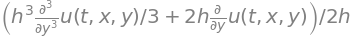

In [26]:
(T(u, 0, 0, 1)-T(u, 0, 0, -1))/(2*h)

In [29]:
def clip(f):
    f = f.expand()
    return [f.coeff(tau, 0).coeff(h, 0), f.coeff(tau, 1), f.coeff(h, 2)]

def df2m(a):
    assert a.func == Derivative
    m = pda_fun[a.args[0]]
    for xi in a.args[1:]:
        if isinstance(xi, Symbol):
            m = m*pda_var[xi]
        else:
            m = m*pda_var[xi[0]]**xi[1]
    return m

def m2df(m):
    r = pda_f[m[0]-1]
    for i in range(1, len(m)):
        r = r.diff(pda_v[i-1], m[i])
    return r

def findDiv(a, d):
    r = None
    def find(a, r):
        if a.args:
            if a.func == Derivative and a.args[0] in pda_fun:
                m = df2m(a)
                if m.divisible(d) and (not r or m.cmp(r) > 0):
                    r = m
            else:
                for s in a.args:
                    r = find(s, r)
        return r
    return find(a, r)

def reduction(f1, f2, m, c, shift):
    assert shift < pda_clp
    r = [f1[i] for i in range(shift)]
    if not m:
        for i in range(shift, pda_clp):
            r.append(expand(f1[i] - f2[i-shift]*c))
    else:
        for i in range(shift, pda_clp):
            r.append(expand(f1[i] - f2[i-shift].diff(*m)*c))
    return r

def NF(f, df, G, trace=False):
    assert len(df) == len(G)
#     print(df2m(df[0]))
    ms = [df2m(d) for d in df]
    for i in range(1, pda_clp):
        t = 0
        if f[i]:
            while True:
                r = None
                for l in range(len(ms)):
                    r = findDiv(f[i], ms[l])
                    if r:
                        break
                if not r: 
                    break
                c, deg, m = 0, 7, m2df(r)
                while c == 0:
                    c = f[i].coeff(m, deg)
                    deg -= 1
                    assert deg >= 0
#                 print(c, m, deg+1)
                if deg:
                    c *= m**deg
                m = r/ms[l]
                d = []
                for k in range(len(pda_v)):
                    if m[k+1] > 0:
                        d.append(pda_v[k])
                        if m[k+1] > 1:
                            d.append(m[k+1])
                if trace:
                    print(">"*12)
                    eq = Symbol("eq%d" % (l+1), real=True)
                    if d:
                        display(Derivative(*tuple([eq] + d))*c*h**i)
                    else:
                        display(eq*c*h**i)
                f = reduction(f, G[l], tuple(d), c, i)
                if trace:
                    print("res =")
                    display(f)
                    print("<"*12)
                t += 1
#                 if t > 6: break
    return f

In [11]:
def Dx(a):
    return (T(a, 0, 1, 0)-T(a, 0, -1, 0))/(2*h)
def Dy(a):
    return (T(a, 0, 0, 1)-T(a, 0, 0, -1))/(2*h)

def DD(a):
    return (T(a, 0, 1, 0) + T(a, 0, 0, 1) +\
                        -4*a +\
           T(a, 0, -1, 0) + T(a, 0, 0, -1))/h**2

def DD2(a):
    return (T(a, 0, 2, 0) + T(a, 0, 0, 2) +\
                        -4*a +\
           T(a, 0, -2, 0) + T(a, 0, 0, -2))/(4*h**2)

def Dxx(a):
    return (T(a, 0, 2, 0) - 2*a + T(a, 0, -2, 0))/(4*h**2)
def Dxy(a):
    return (T(a, 0, 1, 1) - T(a, 0, 1, -1) -\
            T(a, 0, -1, 1) + T(a, 0, -1, -1))/(4*h**2)
def Dyy(a):
    return (T(a, 0, 0, 2) - 2*a + T(a, 0, 0, -2))/(4*h**2)

def DDx(a):
    return (T(a, 0, 2, 0) + T(a, 0, 1, 1) -\
            4.*T(a, 0, 1, 0) + T(a, 0, 1, -1)) -\
           (T(a, 0, -1, 1) - 4.*T(a, 0, -1, 0) +\
            T(a, 0, -2, 0) + T(a, 0, -1, -1))
def DDy(a):
    return (T(a, 0, 1, 1) + T(a, 0, 0, 2) -\
            4.*T(a, 0, 0, 1) + T(a, 0, -1, 1)) -\
           (T(a, 0, 1, -1) - 4.*T(a, 0, 0, -1) +\
            T(a, 0, -1, -1) + T(a, 0, 0, -2))

**FDA1**


Amodio Pierluigi, Blinkov Yuri, Gerdt Vladimir, La Scala Roberto Algebraic construction and numerical behavior of a new s-consistent difference scheme for the 2D Navier–Stokes equations. Applied Mathematics and Computation, 2017, vol. 314, pp. 408-421. DOI: 10.1016/j.amc.2017.06.037 Available at: http://www.sciencedirect.com/science/article/pii/S0096300317304502

page 415

\begin{equation}
\left\lbrace 
\begin{array}{rl}
F^1:& \operatorname{D_1}(u) + \operatorname{D_2}(v)=0 ,\\[4pt]
F^2:& \operatorname{D_t}(u) + \operatorname{D_1}(u^2)+
\operatorname{D_2}(vu) + 
\operatorname{D_1}(p) - \frac{1}{\mathrm{Re}} \tilde{\Delta} (u)
=0 ,\\[4pt]
F^3:& \operatorname{D_t}(v) + \operatorname{D_1}(uv)+
\operatorname{D_2}(v^2) +
\operatorname{D_2}(p) - \frac{1}{\mathrm{Re}} \tilde{\Delta} (v)
=0 ,\\[4pt]
F^4:& \left(\operatorname{D_1}^2 + \operatorname{D_2}^2\right)(p) + \operatorname{D_1}^2(u^2) + \operatorname{D_2}^2(v^2) + {} \\
&{} + 2\operatorname{D_1}\operatorname{D_2}(uv)
- \frac{1}{\mathrm{Re}}\tilde{\Delta}(F^1)
=0 .
\end{array}
\right. 
\end{equation}

In [14]:
F1 = clip(Dx(u) + Dy(v))
F2 = clip((T(u, 1, 0, 0)-T(u, 0, 0, 0))/tau +\
     Dx(u**2) + Dy(v*u) + Dx(p) - DD(u)/Re)
F3 = clip((T(v, 1, 0, 0)-T(v, 0, 0, 0))/tau +\
     Dx(u*v) + Dy(v**2) + Dy(p) - DD(v)/Re)
F4 = clip(DD2(p) + Dxx(u**2) + Dyy(v**2) + 2*Dxy(u*v) - (DDx(u) + DDy(v))/Re)

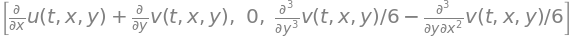

In [30]:
NF(F1, [u.diff(x)], [F1])

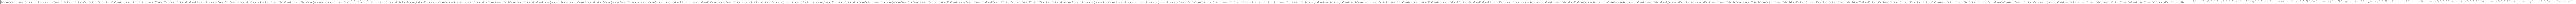

In [20]:
NF(F2, [u.diff(x), u.diff(t), v.diff(t), p.diff(x, 2)], [F1, F2, F3, F4])

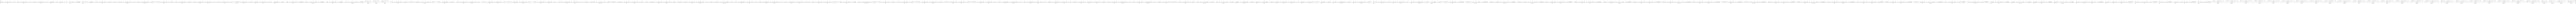

In [21]:
NF(F3, [u.diff(x), u.diff(t), v.diff(t), p.diff(x, 2)], [F1, F2, F3, F4])

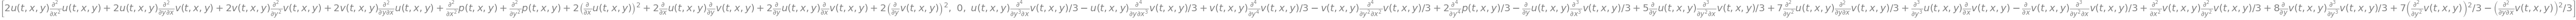

In [22]:
NF(F4, [u.diff(x), u.diff(t), v.diff(t), p.diff(x, 2)], [F1, F2, F3, F4])